In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from scipy import stats
from scipy.stats import norm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV

from statsmodels.regression.linear_model import OLS

sns.set_theme(style="whitegrid")

In [2]:
train_df = pd.read_csv("../data/train.csv", date_parser="Date", dtype={"StateHoliday" : str})
store = pd.read_csv("../data/store.csv")

In [3]:
train_df = train_df[train_df['Open']==1].copy()

In [4]:
train_df = train_df.merge(
    store,
    how="left",
    on = "Store",
)

In [5]:
print(len(train_df))
train_df.head()

844392


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
train_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
train_df.isnull().mean().sort_values(ascending=False)*100

PromoInterval                50.131574
Promo2SinceYear              50.131574
Promo2SinceWeek              50.131574
CompetitionOpenSinceYear     31.812120
CompetitionOpenSinceMonth    31.812120
CompetitionDistance           0.258884
DayOfWeek                     0.000000
Promo2                        0.000000
Assortment                    0.000000
Store                         0.000000
SchoolHoliday                 0.000000
StateHoliday                  0.000000
Promo                         0.000000
Open                          0.000000
Customers                     0.000000
Sales                         0.000000
Date                          0.000000
StoreType                     0.000000
dtype: float64

In [8]:
def split_date(df):
  df['Date'] = pd.to_datetime(df['Date'])
  df['Year'] = df.Date.dt.year
  df['Month'] = df.Date.dt.month
  df['Day'] = df.Date.dt.day
  df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [9]:
split_date(train_df)
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31


In [10]:
def comp_months(df):
#   df['IsCompetition'] = df['CompetitionDistance'].isnull().astype(int)
  df['CompetitionAge'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
  df['CompetitionAge'] = df['CompetitionAge'].map(lambda x: 0 if x < 0 else x).fillna(0)
  

In [11]:
comp_months(train_df)
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionAge
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,2008.0,0,NaN,NaN,NaN,2015,7,31,31,82.0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,2009.0,0,NaN,NaN,NaN,2015,7,31,31,70.0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,2015.0,0,NaN,NaN,NaN,2015,7,31,31,3.0


In [12]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Age'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Age'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Age'] = df['Promo2Age'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    #df['IsPromo2Applied'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [13]:
promo_cols(train_df)
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionAge,Promo2Age
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0,NaN,NaN,NaN,2015,7,31,31,82.0,0.000000
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0,64.131148
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0,51.901639
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,0,NaN,NaN,NaN,2015,7,31,31,70.0,0.000000
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,0,NaN,NaN,NaN,2015,7,31,31,3.0,0.000000


In [14]:
train_df['StateHoliday'].value_counts()/len(train_df)

0    0.998922
a    0.000822
b    0.000172
c    0.000084
Name: StateHoliday, dtype: float64

In [15]:
train_df['DayOfWeek'].value_counts()/len(train_df)

6    0.170606
2    0.170491
3    0.168093
5    0.164189
1    0.162910
4    0.159457
7    0.004255
Name: DayOfWeek, dtype: float64

In [16]:
train_df.to_csv("../data/train_new.csv", index=False)

In [17]:
features = ['Store', 'DayOfWeek', 'Day', 'Month', 'WeekOfYear', 'Year', 'Promo', 'StateHoliday', \
    'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionAge', \
    'Promo2', 'Promo2Age', 'Customers'
]

features_target=['Sales','Store', 'DayOfWeek', 'Day', 'Month', 'WeekOfYear', 'Year', 'Promo', 'StateHoliday', \
    'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionAge', \
    'Promo2', 'Promo2Age', 'Customers']

numeric_feats = ['Store', 'Day', 'Month', 'Year', 'WeekOfYear', 'Promo', 'SchoolHoliday', 'CompetitionDistance', \
    'CompetitionAge', 'Promo2Age', 'Promo2' 
]

categorical_feats = [ 'DayOfWeek','StateHoliday', 'StoreType', 'Assortment']


## 2. Modelisation

### 2.1. Preprocessing

#### 2.1.1. Numeric features

In [18]:
train_df[numeric_feats].isna().sum()

Store                     0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionAge            0
Promo2Age                 0
Promo2                    0
dtype: int64

In [19]:
train_df[numeric_feats].isna().sum()

Store                     0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionAge            0
Promo2Age                 0
Promo2                    0
dtype: int64

In [20]:
max_distance = train_df.CompetitionDistance.max()
max_distance

75860.0

In [21]:
train_df['CompetitionDistance'].fillna(max_distance * 10, inplace=True)

In [22]:
train_df.to_csv("../data/train_new.csv", index=False)

In [23]:
train_df[numeric_feats].isna().sum()

Store                  0
Day                    0
Month                  0
Year                   0
WeekOfYear             0
Promo                  0
SchoolHoliday          0
CompetitionDistance    0
CompetitionAge         0
Promo2Age              0
Promo2                 0
dtype: int64

In [24]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionAge,Promo2Age
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0,NaN,NaN,NaN,2015,7,31,31,82.0,0.000000
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0,64.131148
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0,51.901639
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,0,NaN,NaN,NaN,2015,7,31,31,70.0,0.000000
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,0,NaN,NaN,NaN,2015,7,31,31,3.0,0.000000


<AxesSubplot:>

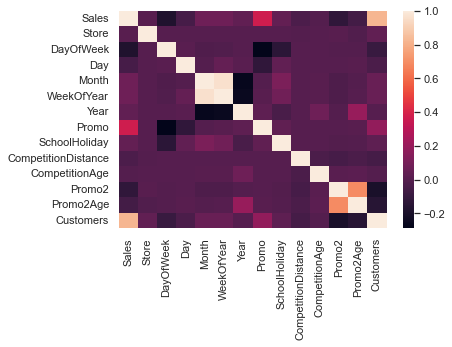

In [25]:
sns.heatmap(train_df[features_target].corr())

C:\Users\Asus\AppData\Local\Temp/ipykernel_4824/257662211.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corrmat, dtype=np.bool)


<AxesSubplot:>

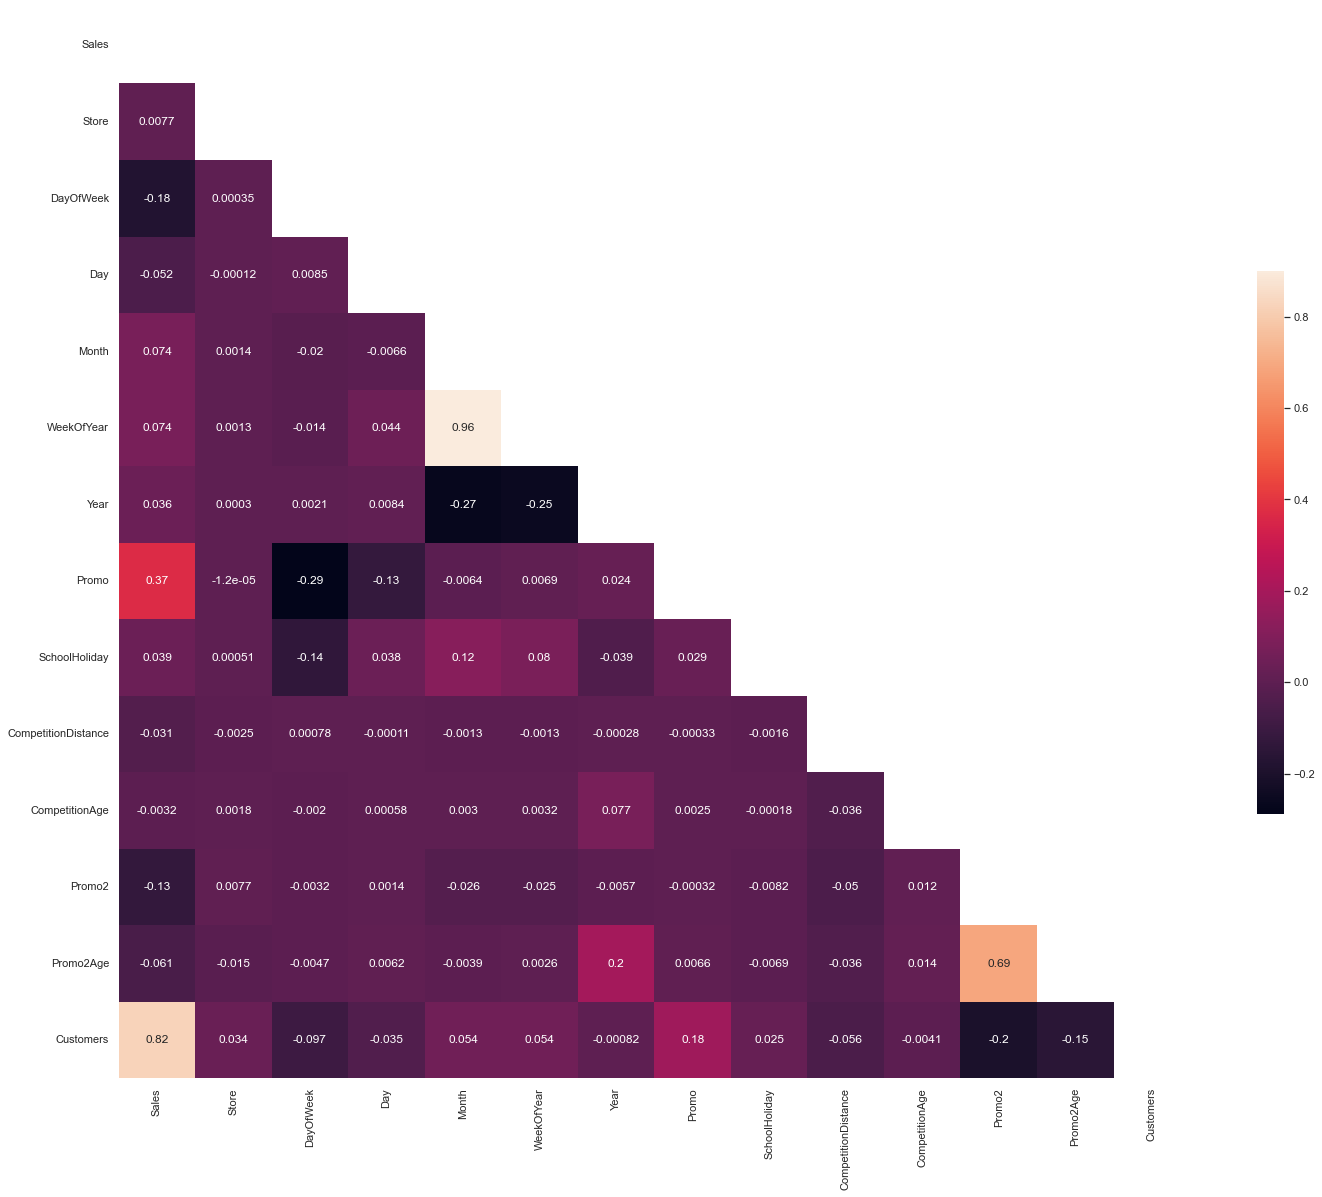

In [26]:
corrmat=train_df[features_target].corr()
plt.subplots(figsize=(24,20))
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrmat, vmax=0.9, square=True, annot=True, mask=mask, cbar_kws={"shrink": .5})

The target variables in strongly correlated with: 'Customers' followed by 'Promo'. It is weekly correlated with 'Promo2' and 'DayofWeek'.

The number of customers in highly Correlated with 'Promo' so it will be useless to use both variables in our model and since the number of customers can be explained by the application of a promotion, we will use 'Promo' in the model.

Month and WeekOfYear are highly correlated, same when it comes to Promo2 and Promo2.Age

In [27]:
train_df[numeric_feats].describe()

,Store,Day,Month,Year,WeekOfYear,Promo,SchoolHoliday,CompetitionDistance,CompetitionAge,Promo2Age,Promo2
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,15.835683,5.845738,2013.831937,23.646801,0.446352,0.193580,7407.747575,41.953548,13.043710,0.498684
std,321.731914,8.683456,3.323931,0.777260,14.389785,0.497114,0.395103,39057.415875,65.189741,18.987353,0.499999
min,1.000000,1.000000,1.000000,2013.000000,1.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000
25%,280.000000,8.000000,3.000000,2013.000000,11.000000,0.000000,0.000000,710.000000,0.000000,0.000000,0.000000
50%,558.000000,16.000000,6.000000,2014.000000,23.000000,0.000000,0.000000,2330.000000,16.000000,0.000000,0.000000
75%,837.000000,23.000000,8.000000,2014.000000,35.000000,1.000000,0.000000,6910.000000,73.000000,24.918033,1.000000
max,1115.000000,31.000000,12.000000,2015.000000,52.000000,1.000000,1.000000,758600.000000,1386.000000,72.000000,1.000000


#### 2.2.2. Categorical Features

In [1]:
def one_hot_encoding(X):
  encoder = OneHotEncoder(sparse=False)
  features = ['StoreType', 'StateHoliday', 'DayOfWeek']
  X_encoded = pd.DataFrame(encoder.fit_transform(X[features]))
  X_encoded.columns = encoder.get_feature_names(features)
  tmp = X.drop(features, axis=1)
  X_encoded = pd.concat([tmp, X_encoded], axis=1)
  return X_encoded


def label_encoding(X):
  encoder = LabelEncoder()
  X['Assortment'] = encoder.fit_transform(X['Assortment'])
  return X

In [28]:
train_df = one_hot_encoding(train_df)
train_df = label_encoding(train_df)
train_df.head()

['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

In [29]:
print('--Before--')
print(train_df['Assortment'].value_counts())
# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
train_df['Assortment'] = ordinal_encoder.fit_transform(train_df['Assortment'].values.reshape(-1, 1))
print('--After--')
print(train_df['Assortment'].value_counts())

--Before--
a    444909
c    391271
b      8212
Name: Assortment, dtype: int64
--After--
0.0    444909
2.0    391271
1.0      8212
Name: Assortment, dtype: int64


In [30]:
print('--Before--')
print(train_df['StateHoliday'].value_counts())
# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
train_df['StateHoliday'] = ordinal_encoder.fit_transform(train_df['StateHoliday'].values.reshape(-1, 1))
print('--After--')
print(train_df['StateHoliday'].value_counts())

--Before--
0    843482
a       694
b       145
c        71
Name: StateHoliday, dtype: int64
--After--
0.0    843482
1.0       694
2.0       145
3.0        71
Name: StateHoliday, dtype: int64


In [31]:
print('--Before--')
print(train_df['StoreType'].value_counts())
# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
train_df['StoreType'] = ordinal_encoder.fit_transform(train_df['StoreType'].values.reshape(-1, 1))
print('--After--')
print(train_df['StoreType'].value_counts())

--Before--
a    457077
d    258774
c    112978
b     15563
Name: StoreType, dtype: int64
--After--
0.0    457077
3.0    258774
2.0    112978
1.0     15563
Name: StoreType, dtype: int64


In [32]:
# print('--Before--')
# print(train_df['StoreType'].value_counts())
# # define one hot encoding
# encoder = OneHotEncoder(drop='first', sparse=False)
# # transform data
# train_df['StoreType'] = encoder.fit_transform(train_df['StoreType'].values.reshape(-1,1))
# print('--After--')
# print(train_df['StoreType'].value_counts())

In [33]:
print('--Before--')
print(train_df['DayOfWeek'].value_counts())
# define one hot encoding
encoder = OneHotEncoder(drop='first', sparse=False)
# transform data
train_df['DayOfWeek'] = encoder.fit_transform(train_df['DayOfWeek'].values.reshape(-1,1))
print('--After--')
print(train_df['DayOfWeek'].value_counts())

--Before--
6    144058
2    143961
3    141936
5    138640
1    137560
4    134644
7      3593
Name: DayOfWeek, dtype: int64
--After--
0.0    700431
1.0    143961
Name: DayOfWeek, dtype: int64


In [34]:
inputs = train_df[features].copy()
target = train_df['Sales'].copy()

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(
    inputs, target, test_size=1/4, random_state=12)

print("Training data length : ", X_train.shape[0]/len(inputs)*100)
print("Test data length : ", len(X_test)/len(inputs)*100)

Training data length :  75.0
Test data length :  25.0


In [37]:
from sklearn.preprocessing import MinMaxScaler

In [38]:
scaler = MinMaxScaler()

X_train[numeric_feats] = scaler.fit_transform(X_train[numeric_feats])
X_test[numeric_feats] = scaler.transform(X_test[numeric_feats])

C:\Users\Asus\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\Users\Asus\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


### 2.2. Linear model Sckit Learn

#### 2.2.1. Linear model Sckit Learn

In [39]:
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)
print("The model parameters")
print("--------------------------------------")
print('Intercept is {}'.format(lin_model.intercept_))
print('Coefficients are {}'.format(lin_model.coef_))
print("\n")

# model evaluation for training set
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model parameters
--------------------------------------
Intercept is 673.6572210640534
Coefficients are [ -182.20951151   -52.7234757     50.75289341   552.64229022
  -173.50341844   241.39696584  1370.88842731 -1311.46287416
    73.82088155   273.52383927   240.76583936   583.61459081
   689.3069077    -79.9465691    682.52469657     6.2929123 ]


The model performance for training set
--------------------------------------
RMSE is 1528.1028823486545
R2 score is 0.7577275747650754


The model performance for testing set
--------------------------------------
RMSE is 1526.1781459975732
R2 score is 0.7581187020881407


#### 2.2.2. Distribution of residuals


 mu = 1.92 and sigma = 1526.18

Shapiro-Wilk test p-value: 0.0


C:\Users\Asus\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\Asus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


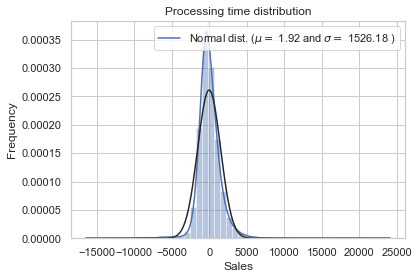

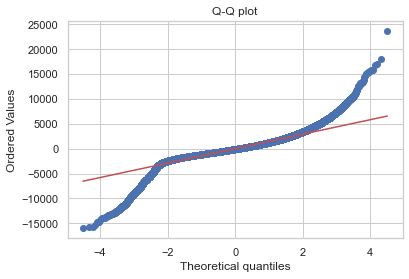

In [40]:
residuals = (Y_test- y_test_predict)
(mu, sigma) = norm.fit(residuals)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

_, p_value = stats.shapiro(residuals)
print('Shapiro-Wilk test p-value: ' + str(p_value))

# Get the fitted parameters used by the function
sns.distplot(residuals , fit=norm)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Processing time distribution')
plt.show()

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(residuals, plot=plt)
plt.title('Q-Q plot')
plt.show()

# 2.3. OLS

In [41]:
OLS_model = OLS(Y_train, X_train)
results = OLS_model.fit()
print(results.summary())

print("Parameters: ", results.params)
print("R2: ", results.rsquared)


                                 OLS Regression Results                                
Dep. Variable:                  Sales   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                          9.344e+05
Date:                Thu, 02 Dec 2021   Prob (F-statistic):                        0.00
Time:                        23:27:50   Log-Likelihood:                     -5.5448e+06
No. Observations:              633294   AIC:                                  1.109e+07
Df Residuals:                  633278   BIC:                                  1.109e+07
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

# 2.4. Ridge Vs Lasso

In [42]:
ridge = Ridge(alpha=0.1)
_ = ridge.fit(X_train, Y_train)

print("The model parameters")
print("--------------------------------------")
print('Intercept is {}'.format(ridge.intercept_))
print('Coefficients are {}'.format(ridge.coef_))
print("\n")

# model evaluation for training set
y_train_predict_ridge = ridge.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict_ridge)))
r2 = r2_score(Y_train, y_train_predict_ridge)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict_ridge = ridge.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict_ridge)))
r2 = r2_score(Y_test, y_test_predict_ridge)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model parameters
--------------------------------------
Intercept is 673.6598988672804
Coefficients are [ -182.20923686   -52.72307916    50.75166391   552.62444354
  -173.48444711   241.39747251  1370.88743107 -1311.37386571
    73.82115215   273.52383051   240.76556834   583.57821009
   689.25567155   -79.94545345   682.52128246     6.29291157]


The model performance for training set
--------------------------------------
RMSE is 1528.102882358485
R2 score is 0.7577275747619582


The model performance for testing set
--------------------------------------
RMSE is 1526.1781074819692
R2 score is 0.7581187142966817


In [43]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.arange(1, 100, 5), scoring='r2', cv=10)
_ = ridge.fit(X_train, Y_train)

In [44]:
alpha_optimal=ridge.alpha_
print(alpha_optimal)
'1'

1


'1'

In [45]:
ridge = Ridge(alpha=1)
_ = ridge.fit(X_train, Y_train)

print("The model parameters")
print("--------------------------------------")
print('Intercept is {}'.format(ridge.intercept_))
print('Coefficients are {}'.format(ridge.coef_))
print("\n")

# model evaluation for training set
y_train_predict_ridge = ridge.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict_ridge)))
r2 = r2_score(Y_train, y_train_predict_ridge)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict_ridge = ridge.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict_ridge)))
r2 = r2_score(Y_test, y_test_predict_ridge)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model parameters
--------------------------------------
Intercept is 673.6839840386992
Coefficients are [ -182.20676495   -52.71951169    50.74060293   552.4639021
  -173.31379076   241.40202943  1370.87846503 -1310.57333398
    73.82358666   273.52375182   240.76313054   583.25099004
   688.79488729   -79.93541284   682.49055889     6.29290507]


The model performance for training set
--------------------------------------
RMSE is 1528.1028833305352
R2 score is 0.7577275744537316


The model performance for testing set
--------------------------------------
RMSE is 1526.1777619015988
R2 score is 0.7581188238375202


In [46]:
lasso = LassoCV(alphas=np.arange(0.000000001, 1, 0.05), cv=10)
_ = lasso.fit(X_train, Y_train)

print('Best alpha:', lasso.alpha_)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2917569200.3125, tolerance: 550290143.5642105
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2905811988.1989746, tolerance: 548591097.5974655
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2907113181.137207, tolerance: 548359080.1143516
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: Converg

Best alpha: 1e-09


In [47]:
lasso = Lasso(alpha=1e-09)
_ = lasso.fit(X_train, Y_train)

print("The model parameters")
print("--------------------------------------")
print('Intercept is {}'.format(lasso.intercept_))
print('Coefficients are {}'.format(lasso.coef_))
print("\n")

# model evaluation for training set
y_train_predict_lasso = lasso.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict_lasso)))
r2 = r2_score(Y_train, y_train_predict_lasso)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict_lasso = lasso.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict_lasso)))
r2 = r2_score(Y_test, y_test_predict_lasso)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model parameters
--------------------------------------
Intercept is 673.6572210866079
Coefficients are [ -182.2095115    -52.72347569    50.75289337   552.6422899
  -173.50341809   241.39696584  1370.88842731 -1311.46287374
    73.82088155   273.52383927   240.76583936   583.61459042
   689.30690723   -79.94656908   682.52469653     6.2929123 ]


The model performance for training set
--------------------------------------
RMSE is 1528.1028823486545
R2 score is 0.7577275747650754


The model performance for testing set
--------------------------------------
RMSE is 1526.1781459973915
R2 score is 0.7581187020881983


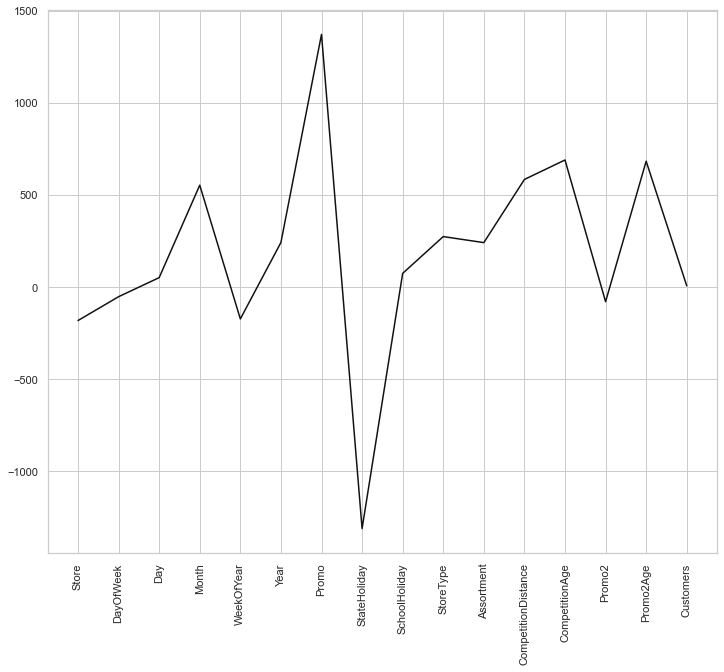

In [48]:
fig, ax = plt.subplots(figsize=(12, 10))

ax.plot(X_train.columns, lasso.coef_, color='#111111')

plt.setp(ax.get_xticklabels(), rotation=90);

In [49]:
print("Number of features before Lasso:", len(lasso.coef_))
print("Number of features after fitting Lasso:", len(lasso.coef_[lasso.coef_ > 0]))
print("Relevant features:", X_train.columns[lasso.coef_ > 0])

Number of features before Lasso: 16
Number of features after fitting Lasso: 11
Relevant features: Index(['Day', 'Month', 'Year', 'Promo', 'SchoolHoliday', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionAge', 'Promo2Age',
       'Customers'],
      dtype='object')


In [61]:
relevant_features=[ 'Month', 'Year', 'Promo', 'SchoolHoliday', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionAge', 'Promo2Age',
       'Customers']

X_train_new=X_train[relevant_features]
X_test_new=X_test[relevant_features]

In [62]:
lin_model_select = LinearRegression()
lin_model_select.fit(X_train_new, Y_train)
print("The model parameters")
print("--------------------------------------")
print('Intercept is {}'.format(lin_model_select.intercept_))
print('Coefficients are {}'.format(lin_model_select.coef_))
print("\n")

# model evaluation for training set
y_train_predict = lin_model_select.predict(X_train_new)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lin_model_select.predict(X_test_new)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model parameters
--------------------------------------
Intercept is 565.0346897393001
Coefficients are [ 403.39080494  257.64752439 1363.62870777   73.12677951  273.76889938
  239.25108905  604.02386141  676.81080057  577.28454437    6.28950362]


The model performance for training set
--------------------------------------
RMSE is 1530.819192163085
R2 score is 0.7568654968619986


The model performance for testing set
--------------------------------------
RMSE is 1528.1939839922766
R2 score is 0.757479306840003


# 2.5. Random Forrest

In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

random_forest = RandomForestRegressor() 

random_forest.fit(X_train, Y_train)
y_pred = random_forest.predict(X_test) 

In [ ]:

random_forest_tuning = RandomForestRegressor()
param_grid = {
   'n_estimators': [100, 200, 500],
   'max_features': ['auto', 'sqrt', 'log2'],
   'max_depth' : [4,5,6,7,8],
   'criterion' :['mse', 'mae']
}
GSCV = GridSearchCV(estimator=random_forest_tuning, param_grid=param_grid, cv=5)
GSCV.fit(X_train, Y_train)
GSCV.best_params_ 

In [ ]:
random_forest = RandomForestRegressor()
random_forest.fit(X_train, Y_train)
y_pred = random_forest.predict(X_test)
print('MAE: ', mean_absolute_error(Y_test, y_pred))
print('MSE: ', mean_squared_error(Y_test, y_pred)) 